In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import pandas as pd
import os
from cifar_dataset import get_cifar
from model import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec

/home/iangelinin/miniconda3/envs/mlp/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
cifar = get_cifar()
train_images = np.array([im.reshape((3,32,32)).transpose((1,2,0)) for im in cifar.train.images])
test_images = np.array([im.reshape((3,32,32)).transpose((1,2,0)) for im in cifar.test.images])
len_test = len(cifar.test.images)
len_train = len(cifar.train.images)

/home/iangelinin/MLP/mlpractical/SiameseNetworks/CIFAR100/cifar100-train.npz


In [3]:
#helper function to plot image
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,0], cmap='gray')
        ax.axis('off')
    plt.show()

## Create the siamese net feature extraction model

In [4]:
img_placeholder = tf.placeholder(tf.float32, [None, 32, 32, 3], name='img')
net = mynet(img_placeholder, reuse=False)

## Restore from checkpoint and calc the features from all of train data

In [6]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state( os.path.join(os.getcwd(), "model_cifar"))
    saver.restore(sess,  os.path.join(os.getcwd(), "model_cifar/model.ckpt"))
    
    train_feat = sess.run(net, feed_dict={img_placeholder:train_images[:1000]})                

INFO:tensorflow:Restoring parameters from /home/iangelinin/MLP/mlpractical/SiameseNetworks/model_cifar/model.ckpt


## Searching for similar test images from trainset based on siamese feature

In [7]:
#generate new random test image
idx = np.random.randint(0, len_test)
im = test_images[idx]

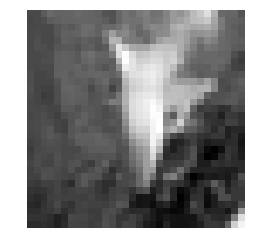

This is image from id: 690


In [8]:
#show the test image
show_image(idx, test_images)
print("This is image from id:", idx)

INFO:tensorflow:Restoring parameters from /home/iangelinin/MLP/mlpractical/SiameseNetworks/model_cifar/model.ckpt


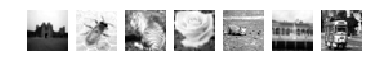

retrieved ids: [549  63 666 622 424 108 749]


In [9]:
#run the test image through the network to get the test features
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state( os.path.join(os.getcwd(), "model_cifar"))
    saver.restore(sess,  os.path.join(os.getcwd(), "model_cifar/model.ckpt"))
    search_feat = sess.run(net, feed_dict={img_placeholder:[im]})
    
#calculate the cosine similarity and sort
dist = cdist(train_feat, search_feat, 'cosine')
rank = np.argsort(dist.ravel())

#show the top n similar image from train data
n = 7
show_image(rank[:n], train_images)
print("retrieved ids:", rank[:n])

In [10]:
cifar.test.labels[690]

73

In [11]:
cifar.train.labels[63]

6

In [12]:
true = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state( os.path.join(os.getcwd(), "model_cifar"))
    saver.restore(sess,  os.path.join(os.getcwd(), "model_cifar/model.ckpt"))
    for i in range(len_test):
        im = test_images[i]
        search_feat = sess.run(net, feed_dict={img_placeholder:[im]})
        dist = cdist(train_feat, search_feat, 'cosine')
        rank = np.argsort(dist.ravel())
        if cifar.test.labels[i] == cifar.train.labels[rank[0]]:
            true += 1
    true/len_test
                                        

INFO:tensorflow:Restoring parameters from /home/iangelinin/MLP/mlpractical/SiameseNetworks/model_cifar/model.ckpt


In [13]:
true/len_test

0.0119